# Machine Learning - Task E

**Part of IAFIG-RMS *Python for Bioimage Analysis* Course.**

*M Kundegorski*

2019-12-13

In this task you will use image information to cluster images into classes based on similarity of colour. In reality we could use any feature but colour is very visual and easy to follow.

There are 6 'classes' (colours) of blob, each of them has different value of hue (but the same mean intensity).

This task is based on a scikit-learn tutorial of k-means clustering: https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_iris.html#sphx-glr-auto-examples-cluster-plot-cluster-iris-py.

## The Task

In one experiment we were able to take a 'branbow'-esque dataset, i.e. every cell is expressing a combination of different fluorophores (colours), and each colour combination represents a type of cell. We imaged these cells with an RGB camera. These cells are sparse so we were easily able to segment them, find their bounding box and create a database of images each containing a single cell. We want to use clustering to automatically identify which cell belongs to which cell-type. Luckily, we've convinced a PhD student to manually label our sample database so we can confirm our results at the end.

Given the colour of our cells we want to automatically, and in an unsupervised fashion, 'cluster' our cells into classes, ignoring other features like shape or size.

1. Let's start by loading our data and visualising the manual class labels in RGB space (other colour spaces would also work)
2. Use k-means clustering to cluster our data and compare it to our manual labels
3. Advanced: Use sum of square errors to identify the correct 'k' to use
4. Advanced: Use mean shift clustering to cluster our data and compare it to our manual labels

## Task E.1

Let's start by loading data. Later on, you can change parameters to see how the clustering results change with different numbers and noise.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

# Utils is a custom module written to simplify these tutorials
# You do not need to understand these codes for this practical
from utils.practice_data import generateBlobsData  # this loads data into a DataFrame
from utils.practice_data import showBlobs  # this allows quick visualisation of the data

imageDir = './assets/simple_blobs/'
number_of_classes = 6
# Is 30 a sufficent number of samples? How much noise can our algorithms deal with?
number_of_samples = 100
noise = 10 #value from 0 to 250
problem = generateBlobsData(imageDir, number_of_classes, number_of_samples, imSize = 100, colour=True, noiseSize = noise)

count     100
unique      6
top         4
freq       23
Name: class, dtype: int64

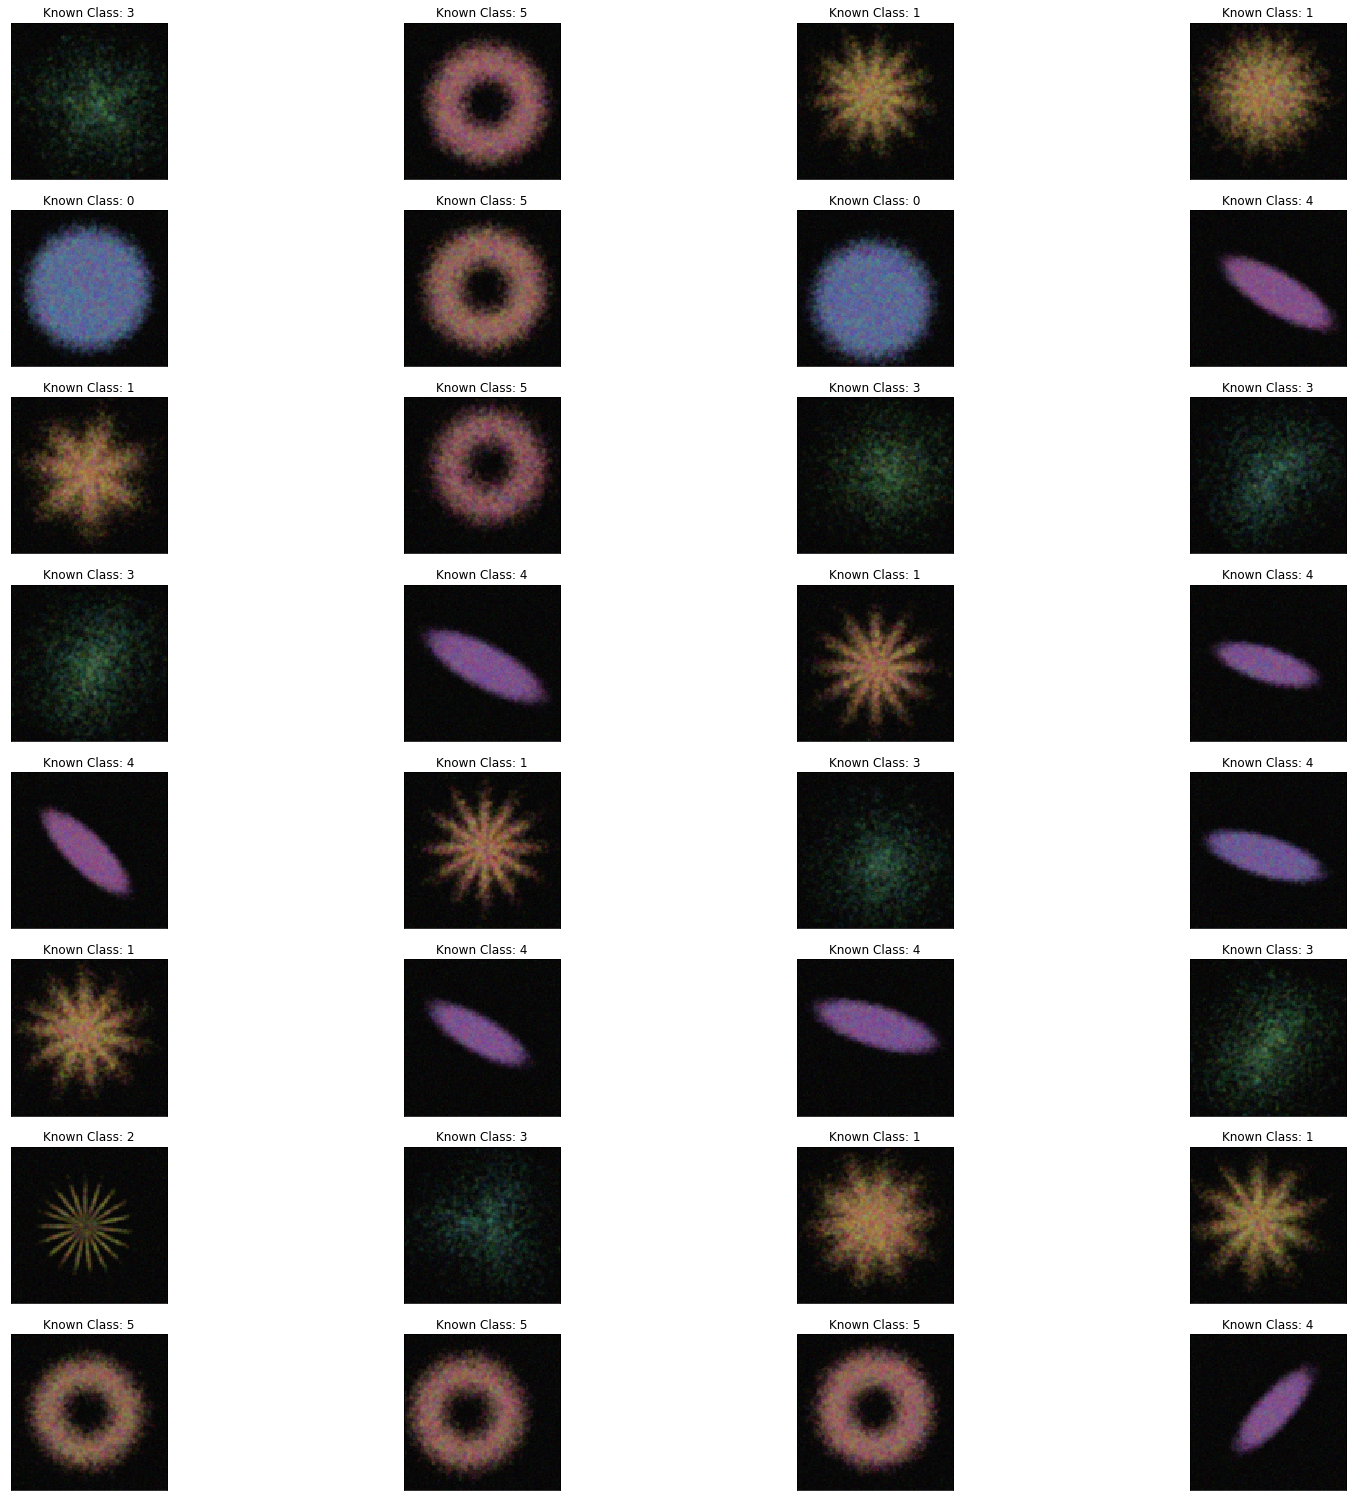

In [2]:
# Visualise
display(problem.loc[:,'class'].describe())  # describe classes
showBlobs(problem.sample(32))

## Task E.2

Time for some data wrangling - as usual the data needs to have right datatype required by the algorithm. For this simple clustering example we're going to extract the mean 'red', the mean 'green' and the mean 'blue' value for each cell. To make things simply, given we've only got one cell per image, we will use the means for the whole image. How might this affect our means and therefore our clustering? Should we use the mean or the median?

Run the following cell to get the median colour channel values.

In [3]:
y=problem.loc[:,'class'].values.astype(int)  # Convert classes to int

for cell in problem.index:
    problem.loc[cell,'mean-R'] = problem.loc[cell,'raw_data'][:,:,0].mean()  # mean of the first (red) channel of our image data for this cell
    problem.loc[cell,'mean-G'] = problem.loc[cell,'raw_data'][:,:,1].mean()  # mean of the second (green) channel of our image data for this cell
    problem.loc[cell,'mean-B'] = problem.loc[cell,'raw_data'][:,:,2].mean()  # mean of the third (blue) channel of our image data for this cell

problem.describe()

,mean-R,mean-G,mean-B
count,100.000000,100.000000,100.000000
mean,31.196496,28.357844,28.255835
std,14.857818,12.154567,15.908319
min,12.712800,13.915400,10.361600
25%,15.941150,17.687625,17.683800
50%,26.317450,23.982050,23.601250
75%,43.597025,36.261000,31.837225
max,63.633500,57.033500,73.009600


Run the following cell to plot our cells on three axes - one for R, one for G and one for B. This code also colourcodes cells by their class (the manual class at the moment).

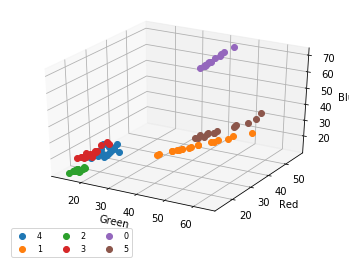

In [4]:
f, axis = plt.subplots(1,1,subplot_kw={'projection':'3d'})  # create a figure with a single 3d axis (subplot)

# Get a list of unique classes
blob_classes = problem.loc[:,'class'].unique()

# Plot each blob and label
for blob_class in blob_classes:
    axis.plot(problem[problem['class']==blob_class]['mean-R'],
            problem[problem['class']==blob_class]['mean-G'],
            problem[problem['class']==blob_class]['mean-B'], 
            'o', label=blob_class)
axis.set_ylabel('Red')
axis.set_xlabel('Green')
axis.set_zlabel('Blue')

axis.legend(loc='upper left', numpoints=1, ncol=3, fontsize=8, bbox_to_anchor=(0, 0))  # add a legend

plt.show()

## Task E.3

Now you will use [sklearn.cluster.kMeans()](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) to perform k-means clustering on your data. This clustering algorithm never sees your manual class labels. Let's see if we can put your PhD student out of a job - I'm sure you have plenty more for them to do!

Run the next cell to do this. How many clusters will you use (fill in the `____`)?

In [5]:
from sklearn import cluster

# Initialise clustering algorithm
k_means = cluster.KMeans(n_clusters=6)  # How would you decide how many clusters to choose?

# Perform fit with colour data only (no class labels)
k_means.fit(problem[['mean-R','mean-G','mean-B']])

# Extract cluster labels
problem['kMeans-cluster'] = k_means.labels_

display(problem.describe())
display(problem.sample(5))

,mean-R,mean-G,mean-B,kMeans-cluster
count,100.000000,100.000000,100.000000,100.000000
mean,31.196496,28.357844,28.255835,2.230000
std,14.857818,12.154567,15.908319,1.824939
min,12.712800,13.915400,10.361600,0.000000
25%,15.941150,17.687625,17.683800,0.000000
50%,26.317450,23.982050,23.601250,2.000000
75%,43.597025,36.261000,31.837225,4.000000
max,63.633500,57.033500,73.009600,5.000000


,class,raw_data,mean-R,mean-G,mean-B,kMeans-cluster
39,4,"[[[8, 4, 16], [6, 5, 6], [8, 10, 3], [6, 13, 5...",26.5722,18.7422,27.2827,4
56,4,"[[[5, 4, 4], [10, 5, 7], [8, 6, 5], [10, 4, 10...",21.5835,16.2996,23.6548,4
5,0,"[[[5, 5, 2], [9, 8, 9], [9, 5, 13], [13, 6, 8]...",37.0906,54.2403,60.7801,3
9,4,"[[[8, 5, 6], [7, 5, 5], [8, 9, 5], [12, 4, 2],...",26.5094,18.6565,26.8121,4
97,5,"[[[9, 5, 6], [4, 13, 12], [10, 5, 7], [6, 0, 1...",51.8939,34.9531,35.2877,2


Run the next cell to plot your PhD student's clustering and the k-means clustering side-by-side. Note that the cluster *numbers* may not map exactly but the cluster *members* should be similar. Have any cells been wrongly classified? Why might that be?

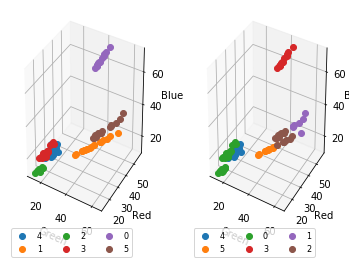

In [6]:
f, ax = plt.subplots(1,2,subplot_kw={'projection':'3d'})  # create a figure with two 3d axes (subplot)
(axPhD, axKM) = ax.flatten()  # give each subplot a unique name

# Get a list of unique PhD-student-derived classes
phd_classes = problem.loc[:,'class'].unique()

# Plot each blob and label
for blob_class in phd_classes:
    axPhD.plot(problem[problem['class']==blob_class]['mean-R'],
            problem[problem['class']==blob_class]['mean-G'],
            problem[problem['class']==blob_class]['mean-B'], 
            'o', label=blob_class)
axPhD.set_ylabel('Red')
axPhD.set_xlabel('Green')
axPhD.set_zlabel('Blue')

axPhD.legend(loc='upper left', numpoints=1, ncol=3, fontsize=8, bbox_to_anchor=(0, 0))  # add a legend

# Get a list of unique k-Means-derived classes
km_classes = problem.loc[:,'kMeans-cluster'].unique()

# Plot each blob and label
for blob_class in km_classes:
    axKM.plot(problem[problem['kMeans-cluster']==blob_class]['mean-R'],
            problem[problem['kMeans-cluster']==blob_class]['mean-G'],
            problem[problem['kMeans-cluster']==blob_class]['mean-B'], 
            'o', label=blob_class)
axKM.set_ylabel('Red')
axKM.set_xlabel('Green')
axKM.set_zlabel('Blue')

axKM.legend(loc='upper left', numpoints=1, ncol=3, fontsize=8, bbox_to_anchor=(0, 0))  # add a legend

plt.show()

## Advanced Task E.4

So far, we used our senses to guess that we needed 6 clusters. However, there is a relatively simple way to estimate the number of clusters we want from a k-means algorithm. First, we guess a reasonable range, for example, 1 to 10 clusters, and run k-means clustering for each guess. We then look for a 'knee' point in Sum of Square Errors (SSE) for each clustering. The SSE (or intertia) is the sum of distances from each sample (each cell) to the centre of it's cluster, e.g. the mean position of all cells in that cluster.

You can access value of SSE using `.inertia_` attribute of a fitted k-means model.

Use a for loop, and by copying the code above, create a cell to first the best 'k' to use for this data.

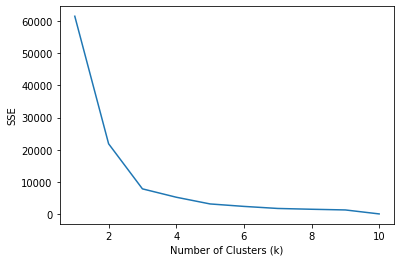

In [10]:
sse = np.zeros(10)  # create an array to hold our sse values

for idx,k in zip(np.arange(len(sse)),np.arange(1, 10)):
    # Initialise clustering algorithm
    k_means = cluster.KMeans(n_clusters=k)  # How would you decide how many clusters to choose?

    # Perform fit with colour data only (no class labels)
    k_means.fit(problem[['mean-R','mean-G','mean-B']])

    # Extract inertia
    sse[idx] = k_means.inertia_

# Plot SSE for different k
f, axis = plt.subplots(1,1)  # create a figure with a single axis (subplot)

axis.plot(np.arange(1,11), sse)
axis.set_ylabel('SSE')
axis.set_xlabel('Number of Clusters (k)')

plt.show()

## Advanced Task E.5

K-means clustering is not the only unsupervised clustering algorithm. Check out [Mean Shift Clustering]().

In a new cell, and using your k-means codes above, do mean shift clustering on this data. What happens when you change the bandwidth parameter?

*Note:* Make sure you save your mean-shift clustering in a column of `problem` called `mean-shift-cluster`; this will make sure the plot cell below works.

In [11]:
### Remove this cell ###
# Initialise clustering algorithm
mean_shift = cluster.MeanShift(bandwidth=10)

# Perform fit with colour data only (no class labels)
mean_shift.fit(problem[['mean-R','mean-G','mean-B']])

# Extract cluster labels
problem['mean-shift-cluster'] = mean_shift.labels_

display(problem.describe())
display(problem.sample(5))
### Remove this cell ###

,mean-R,mean-G,mean-B,kMeans-cluster,mean-shift-cluster
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,31.196496,28.357844,28.255835,2.230000,0.590000
std,14.857818,12.154567,15.908319,1.824939,0.712018
min,12.712800,13.915400,10.361600,0.000000,0.000000
25%,15.941150,17.687625,17.683800,0.000000,0.000000
50%,26.317450,23.982050,23.601250,2.000000,0.000000
75%,43.597025,36.261000,31.837225,4.000000,1.000000
max,63.633500,57.033500,73.009600,5.000000,2.000000


,class,raw_data,mean-R,mean-G,mean-B,kMeans-cluster,mean-shift-cluster
52,4,"[[[4, 2, 5], [9, 13, 6], [9, 10, 9], [4, 6, 6]...",24.3907,16.8975,23.1249,4,0
20,4,"[[[7, 13, 1], [9, 10, 4], [5, 7, 9], [10, 6, 1...",24.9596,18.8472,28.1226,4,0
58,1,"[[[4, 4, 4], [4, 7, 4], [2, 8, 7], [4, 4, 4], ...",43.8719,33.3751,23.5010,5,1
95,5,"[[[12, 7, 9], [2, 13, 8], [2, 6, 8], [9, 9, 10...",49.3554,33.4318,33.6980,2,1
57,5,"[[[8, 8, 8], [11, 10, 3], [6, 15, 4], [2, 3, 7...",55.5075,38.4355,36.8966,1,1


Run the cell below to plot the PhD, k-means and mean-shifted clustering side-by-side.

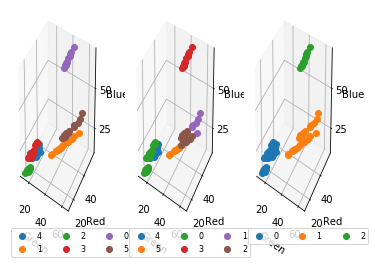

In [12]:
f, ax = plt.subplots(1,3,subplot_kw={'projection':'3d'})  # create a figure with three 3d axes (subplot)
(axPhD, axKM, axMS) = ax.flatten()  # give each subplot a unique name

# Get a list of unique PhD-student-derived classes
phd_classes = problem.loc[:,'class'].unique()

# Plot each blob and PhD-label
for blob_class in phd_classes:
    axPhD.plot(problem[problem['class']==blob_class]['mean-R'],
            problem[problem['class']==blob_class]['mean-G'],
            problem[problem['class']==blob_class]['mean-B'], 
            'o', label=blob_class)
axPhD.set_ylabel('Red')
axPhD.set_xlabel('Green')
axPhD.set_zlabel('Blue')

axPhD.legend(loc='upper left', numpoints=1, ncol=3, fontsize=8, bbox_to_anchor=(0, 0))  # add a legend

# Get a list of unique k-Means-derived classes
km_classes = problem.loc[:,'kMeans-cluster'].unique()

# Plot each blob and k-means cluster
for blob_class in km_classes:
    axKM.plot(problem[problem['kMeans-cluster']==blob_class]['mean-R'],
            problem[problem['kMeans-cluster']==blob_class]['mean-G'],
            problem[problem['kMeans-cluster']==blob_class]['mean-B'], 
            'o', label=blob_class)
axKM.set_ylabel('Red')
axKM.set_xlabel('Green')
axKM.set_zlabel('Blue')

axKM.legend(loc='upper left', numpoints=1, ncol=3, fontsize=8, bbox_to_anchor=(0, 0))  # add a legend

# Get a list of unique mean-shift-derived classes
ms_classes = problem.loc[:,'mean-shift-cluster'].unique()

# Plot each blob and mean-shift cluster
for blob_class in ms_classes:
    axMS.plot(problem[problem['mean-shift-cluster']==blob_class]['mean-R'],
            problem[problem['mean-shift-cluster']==blob_class]['mean-G'],
            problem[problem['mean-shift-cluster']==blob_class]['mean-B'], 
            'o', label=blob_class)
axMS.set_ylabel('Red')
axMS.set_xlabel('Green')
axMS.set_zlabel('Blue')

axMS.legend(loc='upper left', numpoints=1, ncol=3, fontsize=8, bbox_to_anchor=(0, 0))  # add a legend

plt.show()